In [2]:
def fix_layout(width:int=95):
    from IPython.core.display import display, HTML
    display(HTML('<style>.container { width:' + str(width) + '% !important; }</style>'))
    
fix_layout()

In [3]:
import sys

import numpy as np
import matplotlib.pyplot as plt
#from logs import enable_logging, logging 
from importlib import reload
import nnpde.functions.iterative_methods as im
from nnpde.functions import geometries

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

net = nn.Sequential(
    nn.Conv2d(1, 1, 3, padding=1, bias=False),
    nn.Conv2d(1, 1, 3, padding=1, bias=False),
    nn.Conv2d(1, 1, 3, padding=1, bias=False),
)


# Set the optimizer, you have to play with lr: if too big nan
optim = torch.optim.SGD(net.parameters(), lr = 1e-6)
#optim = torch.optim.Adam(net.parameters(), lr=1e-6)
#optim = torch.optim.ASGD(net.parameters())
# SGD seems much faster

for name, param in net.named_parameters():
    print(name, param)

0.weight Parameter containing:
tensor([[[[-0.1570,  0.0694, -0.1131],
          [-0.2399,  0.2712,  0.1869],
          [ 0.1122,  0.2973, -0.0467]]]], requires_grad=True)
1.weight Parameter containing:
tensor([[[[ 0.0993,  0.0929, -0.2626],
          [-0.1346, -0.1666, -0.0153],
          [-0.3233,  0.0181,  0.0487]]]], requires_grad=True)
2.weight Parameter containing:
tensor([[[[-0.1359,  0.2157,  0.0838],
          [ 0.2675, -0.0542,  0.2257],
          [ 0.3278,  0.3130, -0.0171]]]], requires_grad=True)


New one based only on convolutions and pointwise tensor operations, see iterativeMethods.py

In [5]:
losses = []

In [6]:
# Define train dimension
N = 16

for _ in range(20):
    net.zero_grad()

    # Sample k
    k = np.random.randint(1, 20)
    
    B, B_idx = geometries.square_geometry(N)
    
    # Initialize f: we use a zero forcing term for training
    f = torch.zeros(1, 1, N, N)

    # Initialize solution vector randomly 
    initial_u = torch.randn(1, 1, N, N, requires_grad = True)
    
    # Compute ustar = ground_truth solution torch 
    ground_truth = im.jacobi_method(B_idx, B, f, initial_u = None, k = 1000)

    # Solve the same problem, at each iteration the only thing changing are the weights, which are optimized
    # TODO why though? wouldn't it make much more sense to train it more times on different problems? isn't this the same as oversampling each training sample?
    for _ in range(20):
        
        # Compute the solution with the updated weights
        u = im.H_method(net, B_idx, B, f, initial_u, k)
        
        # Define the loss, CHECK if it is correct wrt paper
        loss = F.mse_loss(ground_truth, u)
        
        """ TODO 
        spectral_radius = TODO
        regularization = 1e10
        if spectral_radius > 1
           loss += regularization
        """
        
        # Exit optimization 
        tol = 1e-6
        if loss.item() <= tol:
            break
            
        # Backpropagation
        loss.backward(retain_graph =  False)
        
        # SGD step
        optim.step()
        
        # Store lossses for visualization
        losses.append(loss.item())

for name, param in net.named_parameters():
    print(name, param)

0.weight Parameter containing:
tensor([[[[-0.4726, -0.1969, -0.3822],
          [-0.5077, -0.0218, -0.1030],
          [-0.2469, -0.0435, -0.4378]]]], requires_grad=True)
1.weight Parameter containing:
tensor([[[[-0.1535, -0.1621, -0.4331],
          [-0.3035, -0.3768, -0.1827],
          [-0.5282, -0.1954, -0.1526]]]], requires_grad=True)
2.weight Parameter containing:
tensor([[[[0.0396, 0.4668, 0.2035],
          [0.3759, 0.1215, 0.2919],
          [0.4177, 0.4821, 0.0939]]]], requires_grad=True)


Plot the losses

final loss is 0.005052320659160614


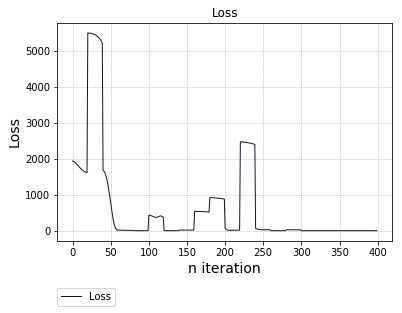

In [7]:
color_map = plt.get_cmap('cubehelix')
colors = color_map(np.linspace(0.1, 1, 10))

losses_fig = plt.figure()
n_iter = np.arange(np.shape(losses)[0])
plt.plot(n_iter, losses, color = colors[0], linewidth = 1, linestyle = "-", marker = "",  label='Loss')

plt.legend(bbox_to_anchor=(0., -0.3), loc=3, borderaxespad=0.)
plt.xlabel('n iteration', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Loss')
plt.grid(True, which = "both", linewidth = 0.5,  linestyle = "--")

print("final loss is {0}".format(losses[-1]))
#losses_fig.savefig('gridSearch.eps', bbox_inches='tight')

Test on a bigger grid

In [8]:
N = 50
nb_iters = 2000

B, B_idx = geometries.square_geometry(N)

# Set forcing term
f = torch.ones(1,1,N,N)*1.0

# Obtain solutions
gtt = im.jacobi_method(B_idx, B, f, torch.ones(1,1,N,N), k = 10000)
output = im.H_method(net, B_idx, B, f, torch.ones(1,1,N,N), k = nb_iters)
jacoby_pure = im.jacobi_method(B_idx, B, f, torch.ones(1,1,N,N), k = nb_iters)

In [13]:
loss_to_be_achieved = 1e-3

u_0 = torch.ones(1, 1, N, N)

needed 4526 iterations (compared to 345), ratio: 13.118840579710145


In [20]:
%%timeit
# old method 
u_k_old = im.jacobi_method(B_idx, B, f, u_0, k = 1)
loss_of_old = F.mse_loss(gtt, u_k_old)
k_count_old = 1
while loss_of_old >= loss_to_be_achieved:
    u_k_old = im.jacobi_method(B_idx, B, f, u_k_old, k = 1)
    loss_of_old = F.mse_loss(gtt, u_k_old)
    k_count_old += 1

906 ms ± 79.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
%%timeit
# new method
u_k_new = im.H_method(net, B_idx, B, f, u_0, k=1)

loss_new = F.mse_loss(gtt, u_k_new)
k_count_new = 1
while loss_new >= loss_to_be_achieved:
    u_k_new = im.H_method(net, B_idx, B, f, u_k_new, k=1)
    loss_new = F.mse_loss(gtt, u_k_new)
    k_count_new += 1

130 ms ± 6.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
print("needed {0} iterations (compared to {1}), ratio: {2}".format(k_count_old, k_count_new, k_count_old/k_count_new))

needed 4526 iterations (compared to 345), ratio: 13.118840579710145


In [ ]:
print("the loss of the new method is {0}, compared to the pure-jacoby one: {1}. computed with {2} iterations".format(F.mse_loss(gtt, output), F.mse_loss(gtt, jacoby_pure), nb_iters))

Z_gtt = gtt.view(N,N).numpy() 
Z_output = output.detach().view(N, N).numpy()

fig, axes = plt.subplots(nrows = 1, ncols = 2)

fig.suptitle("Comparison")

im_gtt = axes[0].imshow(Z_gtt)
axes[0].set_title("Ground truth solution")

im_output = axes[1].imshow(Z_output)
axes[1].set_title("H method solution")

fig.colorbar(im_gtt)
fig.tight_layout()

plt.show()

In [ ]:
np.mean(Z_gtt - Z_output)

In [43]:
np.mean(Z_gtt - Z_jacoby)

TypeError: mean() missing 3 required positional argument: "dim", "keepdim", "dtype"

Test on L-shape domain

In [36]:
B, B_idx = geometries.l_shaped_geometry(N)

# Set forcing term
f = torch.ones(1,1,N,N)*1.0

# Obtain solutions
gtt = im.jacobi_method(B_idx, B, f, torch.ones(1,1,N,N), k = 10000)
output = im.H_method(net, B_idx, B, f, torch.ones(1,1,N,N), k = 2000)

tensor(0.0022, grad_fn=<SumBackward0>)


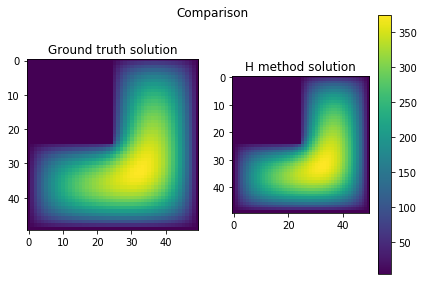

In [37]:
print(F.mse_loss(gtt, output))

Z_gtt = gtt.view(N,N).numpy() 
Z_output = output.detach().view(N, N).numpy()

fig, axes = plt.subplots(nrows = 1, ncols = 2)

fig.suptitle("Comparison")

im_gtt = axes[0].imshow(Z_gtt)
axes[0].set_title("Ground truth solution")

im_output = axes[1].imshow(Z_output)
axes[1].set_title("H method solution")

fig.colorbar(im_gtt)
fig.tight_layout()

plt.show()

Some way to compute the spectral radius maybe helpful. We need to build the matrix H and then compute it.
H is built from the weights. Here we consider only the case conv1

In [ ]:
import scipy as sp
from scipy.linalg import circulant

vector_H = np.zeros(N**2)
vector_H[0] = param[0, 0, 1, 1]
vector_H[1] = param[0, 0, 1, 2]
vector_H[N**2-1] = param[0, 0, 1, 0]

vector_H[N**2-N] = param[0, 0, 0, 1]
vector_H[N**2-N-1] = param[0, 0, 0, 0]
vector_H[N**2-N+1] = param[0, 0, 0, 2]

vector_H[N] = param[0, 0, 2, 1]
vector_H[N-1] = param[0, 0, 2, 0]
vector_H[N+1] = param[0, 0, 2, 2]

p = np.zeros([3,3])
for name, param in net.named_parameters():
    for i in range(3):
        for j in range(3):
            p[i,j] = param[0,0,i,j]

H = np.diag(np.ones(N**2)*p[1,1]) + np.diag(np.ones(N**2-1)*p[1,2], 1) + np.diag(np.ones(N**2-1)*p[1,0], -1) + np.diag(np.ones(N**2-N)*p[2,1], N) + np.diag(np.ones(N**2-N)*p[0,1], -N)



#H = np.transpose(circulant(vector_H))
np.shape(H)
#print(np.real(np.linalg.eigvals(T+H.dot(T)-H)))
Heq = T.numpy()+H.dot(T.numpy())-H
reg = 0.0
#spectral_radius = (np.max(np.real(np.linalg.eigvals(Heq))))

spectral_radius = np.max(np.real(np.fft.fft(vector_T))) + np.max(np.real(np.fft.fft(vector_H)))*np.max(np.real(np.fft.fft(vector_TI)))

In [ ]:
T_I = np.reshape(T.numpy()-I.numpy(), [N**2, N**2])
Tn = np.reshape(T.numpy(), [N**2, N**2])
print(np.max(np.abs(np.real(np.linalg.eigvals(Tn-H.dot(T_I))))))